In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import glob
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import json
import warnings
warnings.filterwarnings('ignore')

# Load new Balanced Training Dataset

In [2]:
train = pd.read_csv("./new_train.csv")
train

,Station,Ob,value,measure,target,R_flag,I_flag,Z_flag,B_flag,temp_wxt,...,sm,temp10,ws02,wd02,gust02,ws06,wd06,gust06,leafwetness,blackglobetemp
0,NEWL,2/14/2021 12:34,0.671,sm,True,0,-1,-1,2,-1.258843,...,2.772014,-1.385473,0.250615,-1.487211,0.038704,0.520901,-1.188249,0.614006,-0.185027,-1.062627
1,SPRU,4/8/2021 7:10,13.520,temp10,True,0,-1,-1,0,-0.434669,...,-0.347779,-0.174979,-0.188056,-0.133357,-0.449335,-0.636664,0.127069,-0.672008,-0.591830,0.000000
2,WINE,1/14/2021 16:34,30.320,sr,False,0,2,-1,-1,-0.615697,...,-0.240413,-0.596850,0.320111,0.349713,0.187520,0.560788,0.126367,0.440945,-0.745593,0.000000
3,WINE,2/1/2021 20:29,0.000,ws02,True,0,4,2,-1,-2.560702,...,-0.084457,-2.682381,-1.256277,-2.299067,-1.327234,2.474934,1.370275,1.895389,-0.446912,0.000000
4,BEAR,6/3/2021 22:04,0.134,sm,False,0,-1,-1,1,0.641464,...,-2.718316,0.371907,-0.273754,-0.163248,-0.315636,-0.246484,-0.175897,-0.095499,0.815865,0.269776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6353868,NEWL,1/5/2021 4:54,0.636,sm,True,0,-1,-1,0,-1.737840,...,2.542184,-1.849172,-0.597638,-1.566183,-0.753927,-0.699913,-1.619639,-0.603107,-0.279829,-1.516225
6353869,NEWL,2/11/2021 8:52,0.571,sm,True,0,-1,-1,2,-0.790733,...,2.115355,-0.881768,-0.739014,-1.279910,-0.753927,0.012144,-1.016178,-0.285415,0.334700,-0.733212
6353870,SPRU,3/17/2021 5:38,13.570,temp10,True,0,-1,-1,1,-0.812166,...,-0.938590,-0.166786,-0.250338,-0.933852,-0.557897,-0.790340,-0.727592,-0.848420,3.125765,0.000000
6353871,GOLD,8/14/2021 14:31,39.980,st,False,2,4,0,1,1.904279,...,0.385904,1.855807,0.271490,0.155175,0.423814,0.433035,-0.103866,0.466815,-0.511260,2.117444


# The current dataset is too big, so we have to sample a subset to work with
## We will cut the training size by 50%

In [6]:
small_train = train.sample(frac=0.5).reset_index(drop=True)

In [12]:
# extract y Labels with thier Station and Ob Data
y = small_train[['target']]
y

,target
0,True
1,False
2,False
3,False
4,False
...,...
3176931,True
3176932,True
3176933,True
3176934,True


In [13]:
# extract X Attributes.

X = small_train.drop(['Station', 'Ob', 'value', 'measure', 'target'], axis=1)
X

,R_flag,I_flag,Z_flag,B_flag,temp_wxt,temp_hmp,rh_wxt,rh_hmp,ws10,wd10,...,sm,temp10,ws02,wd02,gust02,ws06,wd06,gust06,leafwetness,blackglobetemp
0,0,-1,-1,2,-0.779847,-0.796110,-1.178340,-0.946238,-0.141959,-0.072680,...,2.286087,-0.892278,0.391991,-0.105204,0.479055,-0.364113,-0.003918,-0.257176,-0.492292,-0.352408
1,0,-1,-1,1,-1.120471,-1.118277,-0.601081,-0.383550,0.200099,1.417021,...,0.468067,-1.112364,-0.067192,0.368464,0.105591,0.023148,0.543128,0.163418,-0.461578,-1.195200
2,0,-1,0,2,-1.425640,-1.390261,-0.012865,-0.098640,-1.191807,-0.991458,...,-0.283257,-1.863024,-1.045998,0.563014,-1.004008,-1.320920,-1.024279,-1.328128,-0.409550,-1.434565
3,0,-1,0,2,-0.279088,-0.435711,0.881757,1.111946,-0.361721,1.437882,...,-0.535317,-0.414286,-0.495104,0.994010,-0.758610,-0.451373,0.963404,-0.617677,0.719732,-0.469402
4,0,-1,-1,0,-0.801743,-0.812327,-2.247809,-2.322904,-0.050146,-1.304566,...,1.555124,0.000000,0.347123,1.389249,0.513079,0.009097,-1.354676,0.319628,-0.514791,-0.392537
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3176931,0,-1,-1,1,-0.552637,-0.555855,-0.183907,-0.063135,-0.256118,-0.987267,...,-0.245915,-0.170063,-0.188056,1.447622,-0.069367,-0.390665,-0.935052,-0.318773,-0.606877,0.000000
3176932,0,-1,0,0,-1.367101,-1.686717,0.621074,0.401120,-0.855320,0.767559,...,1.862358,-1.583878,0.000000,0.000000,-0.253741,-0.724393,0.899045,-0.808852,0.025706,-1.627217
3176933,0,4,-1,-1,1.676686,1.709074,-1.016980,-0.974613,-0.037585,-0.130594,...,-2.061336,1.681999,-0.252210,-0.433825,-0.199266,0.004192,-0.242352,-0.095109,-0.408460,1.640694
3176934,0,-1,-1,1,-0.965523,-0.970818,1.075746,1.034073,-0.766297,-0.181935,...,0.650489,-0.163509,-0.281479,0.196848,-0.666460,-0.667049,0.018020,-0.696157,2.382709,0.000000


# MLPClassifier
1. first we try a baseline classifier
2. tuning Hyperparameters

In [3]:
# Baseline model with hidden_layer_sizes= (27,4) -> randomly chosen

clt = MLPClassifier(hidden_layer_sizes= (27,4), random_state=24, early_stopping=True)

In [16]:
# print(cross_val_score(clt, X, y, scoring='recall', cv=4))

[0.98394726 0.98503841 0.98782055 0.98696373]


In [18]:
# from joblib import dump, load
# dump(clt, 'model.joblib') 

# clt = load('model.joblib')

['model.joblib']

1. Hyperparameters to look at :
                                hidden_layer_sizes
                                early_stopping

In [3]:
parameters = {'hidden_layer_sizes':[(27,6), (27,7), (27,8)], 'activation': ('logistic', 'tanh')}

# Now Try a GridSearchCV to try and find the best hyper parameters

In [4]:
small_train = train.sample(frac=0.20).reset_index(drop=True)
y = small_train[['target']]
X = small_train.drop(['Station', 'Ob', 'value', 'measure', 'target'], axis=1)

In [5]:
cltCV = GridSearchCV(estimator=MLPClassifier(early_stopping=True),param_grid=parameters, cv=3)

In [6]:
cltCV.fit(X, y)

GridSearchCV(cv=3, estimator=MLPClassifier(early_stopping=True),
             param_grid={'activation': ('logistic', 'tanh'),
                         'hidden_layer_sizes': [(27, 6), (27, 7), (27, 8)]})

In [7]:
cltCV.cv_results_

{'mean_fit_time': array([158.4375666 , 219.5052352 , 252.73230441, 217.62298473,
        156.50474119, 185.56838719]),
 'std_fit_time': array([18.82185576, 29.68982359, 53.45550683, 39.29218809, 13.33447976,
        51.61013438]),
 'mean_score_time': array([0.32778176, 0.32561302, 0.34879994, 0.51627231, 0.50342909,
        0.56715091]),
 'std_score_time': array([0.0050216 , 0.011859  , 0.0074338 , 0.00638674, 0.00534382,
        0.01978355]),
 'param_activation': masked_array(data=['logistic', 'logistic', 'logistic', 'tanh', 'tanh',
                    'tanh'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[(27, 6), (27, 7), (27, 8), (27, 6), (27, 7), (27, 8)],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'activation': 'logistic', 'hidden_layer_sizes': (27, 6)},
  {'activation': 'logistic'

In [8]:
model = cltCV.best_estimator_

In [9]:
cltCV.best_score_

0.980626782828447

# Best MLPClassifier Hyperparameters
### activation: tanh
### hidden_layer_sizes: (27, 6)

In [10]:
cltCV.best_params_

{'activation': 'tanh', 'hidden_layer_sizes': (27, 6)}

In [8]:
clt = MLPClassifier(hidden_layer_sizes= (27,6), random_state=24, activation= 'tanh', early_stopping=True)
y = train[['target']]
X = train.drop(['Station', 'Ob', 'value', 'measure', 'target'], axis=1)

In [4]:
print(cross_val_score(clt, X, y, scoring='recall', cv=4))

[0.99112827 0.99052616 0.99067606 0.98966833]


In [9]:
clt.fit(X, y)

MLPClassifier(activation='tanh', early_stopping=True,
              hidden_layer_sizes=(27, 7), random_state=24)

### Save and lo}ad the model

In [ ]:
from joblib import dump, load
dump(clt, 'new_model.joblib') 

clt = load('new_model.joblib')

# Model Metrics

In [4]:
y = train[['target']]
X = train.drop(['Station', 'Ob', 'value', 'measure', 'target'], axis=1)

y_pred = pd.DataFrame(clt.predict(X),columns = ['y_pred'])

accuracy = sklearn.metrics.accuracy_score(y, y_pred)
precision = sklearn.metrics.precision_score(y, y_pred)
recall = sklearn.metrics.recall_score(y, y_pred)
f1 = sklearn.metrics.f1_score(y, y_pred)

print(accuracy, precision, recall, f1)

0.9827936441285496 0.9755750277560028 0.9903668106868883 0.9829152723966016


## Precision-recall curve

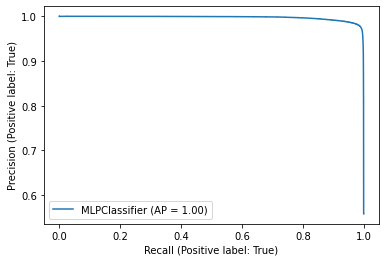

In [7]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

PrecisionRecallDisplay.from_estimator(clt, X, y)
plt.show()

## ROC curve

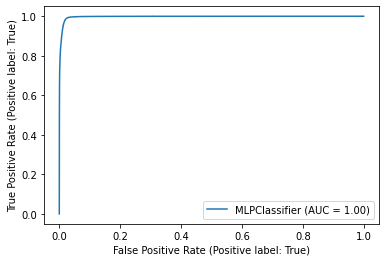

In [8]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clt, X, y)
plt.show()

# Now Use the model on the Test Dataset

#### load the model if you aren't fitting it for the first time

In [11]:
from joblib import dump, load
dump(clt, 'MLP_model.joblib') 

clt = load('MLP_model.joblib')

# Load the full data and merge with the Original Training dataset

In [9]:
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "full/*.csv"))
each_Station = {}

# load each full file
for f in csv_files:
    each_Station[f[101:105].lower()] = pd.read_csv(f)
    
    temp = each_Station[f[101:105].lower()][each_Station[f[101:105].lower()].columns[3:26]]
    temp2 = each_Station[f[101:105].lower()][['Station', 'Ob']]
    
    temp = pd.DataFrame(StandardScaler().fit_transform(temp),columns = temp.columns).fillna(0)
    each_Station[f[101:105].lower()] = pd.concat([temp2, temp], axis=1, join='inner')
    
temp = []

# add each dataframe to a list
for key in each_Station:
    
    temp.append(each_Station[key])

# concat the dataframe, combine all rows
all_stations = pd.concat(temp)

In [10]:
original_train = pd.read_csv("./train.csv")

# merge the testing data and all_station data on 'Station', 'Ob'
original_train_full = pd.merge(original_train, all_stations, how="inner", on=['Station', 'Ob'])

y = original_train_full[['target']]
X = original_train_full.drop(['Station', 'Ob', 'value', 'measure', 'target'], axis=1)


In [11]:
y_pred = pd.DataFrame(clt.predict(X),columns = ['y_pred'])

In [12]:
accuracy = sklearn.metrics.accuracy_score(y, y_pred)
precision = sklearn.metrics.precision_score(y, y_pred)
recall = sklearn.metrics.recall_score(y, y_pred)
f1 = sklearn.metrics.f1_score(y, y_pred)

print(accuracy, precision, recall, f1)

0.9756780925531079 0.5956713787697038 0.9903177248992227 0.7438940447272303


## Model Metrics - on Original Training Data

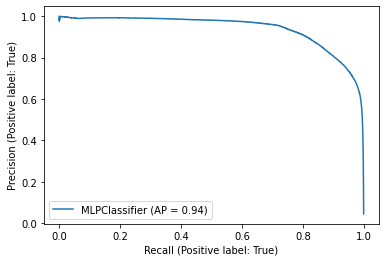

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

PrecisionRecallDisplay.from_estimator(clt, X, y)
plt.show()

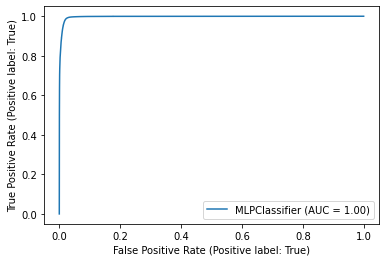

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(clt, X, y)
plt.show()

# Load the full data and merge with the testing datasets

In [3]:
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "full/*.csv"))
each_Station = {}

# load each full file
for f in csv_files:
    each_Station[f[101:105].lower()] = pd.read_csv(f)
    
    temp = each_Station[f[101:105].lower()][each_Station[f[101:105].lower()].columns[3:26]]
    temp2 = each_Station[f[101:105].lower()][['Station', 'Ob']]
    
    temp = pd.DataFrame(StandardScaler().fit_transform(temp),columns = temp.columns).fillna(0)
    each_Station[f[101:105].lower()] = pd.concat([temp2, temp], axis=1, join='inner')
    
temp = []

# add each dataframe to a list
for key in each_Station:
    
    temp.append(each_Station[key])

# concat the dataframe, combine all rows
all_stations = pd.concat(temp)

In [4]:

test = pd.read_csv("./test.csv")


# merge the testing data and all_station data on 'Station', 'Ob'
dfull = pd.merge(test, all_stations, how="inner", on=['Station', 'Ob'])

In [5]:
X = dfull.drop(['Station', 'Ob', 'value', 'measure'], axis=1)
X

,R_flag,I_flag,Z_flag,B_flag,temp_wxt,temp_hmp,rh_wxt,rh_hmp,ws10,wd10,...,sm,temp10,ws02,wd02,gust02,ws06,wd06,gust06,leafwetness,blackglobetemp
0,2,-1,2,0,0.839498,0.787337,-0.783049,-0.503103,0.090042,0.086811,...,0.982932,0.733379,-0.435431,-0.537254,-0.258877,0.182762,-0.306286,0.305015,-0.484017,1.496432
1,2,-1,-1,1,0.839498,0.787337,-0.783049,-0.503103,0.090042,0.086811,...,0.982932,0.733379,-0.435431,-0.537254,-0.258877,0.182762,-0.306286,0.305015,-0.484017,1.496432
2,2,-1,0,1,1.683680,1.665959,-0.552512,-0.431934,1.172638,-0.013927,...,-0.194344,1.605214,-0.201828,-0.188946,-0.071172,0.792664,-0.598164,2.297152,-0.475397,1.858563
3,2,-1,0,1,1.683680,1.665959,-0.305891,-0.555463,0.621299,0.014583,...,-0.194344,1.616265,-0.201828,-0.041178,-0.071172,0.155422,0.188553,0.698464,-0.475397,1.896822
4,3,0,-1,-1,1.683680,1.665959,-0.305891,-0.555463,0.621299,0.014583,...,-0.194344,1.616265,-0.201828,-0.041178,-0.071172,0.155422,0.188553,0.698464,-0.475397,1.896822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1856101,0,0,2,-1,0.965494,0.968128,0.028117,0.011607,0.886390,1.412258,...,0.102690,1.060294,-0.625722,-1.947276,0.103367,1.203057,1.228551,0.921566,-0.687717,0.138841
1856102,0,0,2,-1,0.909523,0.908256,0.039687,0.053045,-0.139385,1.194936,...,0.102690,0.990324,0.109926,1.270578,0.103367,-0.300071,1.191845,-0.249791,-0.684616,0.098119
1856103,0,0,2,-1,0.685637,0.703578,0.637495,0.571206,0.786800,1.313111,...,0.071498,0.741859,0.530295,-2.278374,1.449815,0.145550,1.160238,0.305062,-0.648444,0.000599
1856104,0,0,2,-1,0.391788,0.422320,-0.029736,-0.046095,-0.188557,1.411257,...,-0.084457,0.467692,0.215018,1.405087,-0.064939,-0.157439,1.402902,-0.225256,-0.697018,-0.302678


In [12]:
y_pred = pd.DataFrame(clt.predict(X),columns = ['y_pred'])
y_pred

,y_pred
0,False
1,False
2,False
3,False
4,False
...,...
1856101,False
1856102,False
1856103,False
1856104,False


In [13]:
clt.predict_proba(X)

array([[9.86296315e-01, 1.37036848e-02],
       [9.99999966e-01, 3.37952499e-08],
       [9.90977974e-01, 9.02202573e-03],
       ...,
       [9.50407282e-01, 4.95927180e-02],
       [9.98657882e-01, 1.34211753e-03],
       [9.98605922e-01, 1.39407848e-03]])